# Event-shopping Likelihood Model

## Feature selection

#### In this notebook:
* Investigate features 

In [1]:
import os
import sys
import json

import numpy as np
import pandas as pd

In [2]:
#import statsmodels.api as sm 

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingRegressor
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.utils import resample
from sklearn import metrics

In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import seaborn as sns

In [4]:
%matplotlib inline

In [5]:
def slow_apply(groupby, func): 
    grouper = groupby.grouper

    mutated = grouper.mutated
    splitter = grouper._get_splitter(groupby._selected_obj, groupby.axis)
    group_keys = grouper._get_group_keys()

    result_values = []
    for key, (i, group) in zip(group_keys, splitter):
        object.__setattr__(group, 'name', key)
        
        if isinstance(group, pd.Series): 
            group_axes = [group.index]
        else: 
            group_axes = group.axes
        
        res = func(group)
        
        if not res.index.equals(group_axes[0]) or (isinstance(res, pd.Series) and len(group_axes) > 1):
            mutated = True
        result_values.append(res)
        
    return groupby._wrap_applied_output(group_keys, result_values, not_indexed_same=mutated or groupby.mutated)

In [6]:
key_event_slug = 'annpub17'

In [7]:
events = json.load(open('../json_and_txt/mktg_events.json','r'))

In [76]:
adf = pd.read_csv('../data/ep_{}_data_summary.csv'.format(key_event_slug))
bdf = pd.read_csv('../data/ep_{}_sample_summary.csv'.format(key_event_slug))

In [77]:
adf['pct'] = adf['n_pos']/adf['n']
adf

,persona,n,n_pos,pct
0,1,1730601,165912,0.095870
1,2,2084615,108089,0.051851
2,3,7614173,847419,0.111295
3,4,3852430,890673,0.231198
4,5,1741791,116972,0.067156


In [78]:
bdf['pct'] = bdf['n_pos']/bdf['n']
bdf

,persona,n,n_pos,pct
0,1,50000,4787,0.09574
1,2,50000,2602,0.05204
2,3,50000,5584,0.11168
3,4,50000,11572,0.23144
4,5,50000,3383,0.06766


In [87]:
sdf_train = pd.read_csv('../data/ep_{0}_scaled_train_sample.csv.gz'.format(key_event_slug), 
                        header=0, sep='|', compression='gzip')
sdf_test = pd.read_csv('../data/ep_{0}_scaled_test_sample.csv.gz'.format(key_event_slug), 
                       header=0, sep='|', compression='gzip')
udf_train = pd.read_csv('../data/ep_{0}_unscaled_train_sample.csv.gz'.format(key_event_slug), 
                        header=0, sep='|', compression='gzip')
udf_test = pd.read_csv('../data/ep_{0}_unscaled_test_sample.csv.gz'.format(key_event_slug), 
                       header=0, sep='|', compression='gzip')

In [88]:
partition = 'persona'
target = 'target_shopped_ind'
features = sdf_train.columns.tolist()[3:]

In [90]:
u1 = sdf_train.groupby(partition)[target].agg(['count','sum'])
u1['pct'] = u1['sum']/u1['count']
u2 = sdf_test.groupby(partition)[target].agg(['count','sum'])
u2['pct'] = u2['sum']/u2['count']
print u1
print u2

         count   sum       pct
persona                       
1        35000  3351  0.095743
2        35000  1821  0.052029
3        35000  3909  0.111686
4        35000  8100  0.231429
5        35000  2368  0.067657
         count   sum       pct
persona                       
1        15000  1436  0.095733
2        15000   781  0.052067
3        15000  1675  0.111667
4        15000  3472  0.231467
5        15000  1015  0.067667


In [92]:
(sdf_train['cust_key']==udf_train['cust_key']).all()

True

In [96]:
sdf_train.dtypes

cust_key                            int64
persona                             int64
target_shopped_ind                  int64
tenure_total_months               float64
loyalty_tender_ind                float64
loyalty_nontender_ind             float64
log_fl_total_spend                float64
log_fl_total_trips                float64
log_fl_avg_spend_per_trip         float64
sale_pct_items                    float64
merch_pct_spend                   float64
womens_prod_pct_spend             float64
mens_prod_pct_spend               float64
accessories_pct_spend             float64
apparel_pct_spend                 float64
babypet_pct_spend                 float64
bag_pct_spend                     float64
beauty_pct_spend                  float64
entertainment_pct_spend           float64
food_pct_spend                    float64
home_pct_spend                    float64
jewelry_pct_spend                 float64
other_pct_spend                   float64
shoe_pct_spend                    

In [97]:
sdf_train['months_since_last_squared'] = sdf_train['months_since_last_sale']**2
sdf_test['months_since_last_squared'] = sdf_test['months_since_last_sale']**2

In [98]:
# prints all of the feature pairs with correlations in the range from 1 to lower_bound 
def get_high_corr(df, lower_bound=0.8):
    corr_df = df.corr().abs()
    unstacked = corr_df.unstack()
    unstacked = unstacked.sort_values(ascending=False)
    # print highest correlations
    unstacked = unstacked.loc[(unstacked < 1.0) & (unstacked > lower_bound)]
    unstacked = unstacked.reset_index()
    unstacked.columns = ['feature_1','feature_2','corr']
    #unstacked = unstacked.loc[unstacked['feature_1']!=unstacked['feature_2']]
    unstacked['rank'] = unstacked['corr'].rank(method='dense', ascending=False)
    return unstacked

In [113]:
def get_low_variance(df, upper_bound=0.05):
    var = df.var()
    var = var.loc[var < upper_bound]
    var = var.reset_index()
    var.columns = ['feature','variance']
    var['rank'] = var['variance'].rank(method='dense')
    return var

In [130]:
corr_df = udf_train.groupby(partition)[features].apply(get_high_corr).reset_index()

In [131]:
#corr_df.groupby('feature_1').agg({partition: ['count','nunique'], 'corr': 'sum'}).sort_values(('corr','sum'), ascending=False)

In [132]:
corr_pvt = corr_df.pivot_table(values='corr', index=['feature_1','feature_2'], columns=partition)
corr_pvt['sum'] = corr_pvt.sum(axis=1)

In [133]:
corr_pvt.sort_values('sum',ascending=False)

,persona,1,2,3,4,5,sum
feature_1,feature_2,,,,,,
fl_shopped_ly_ind,log_fl_total_spend_ly,0.877197,0.898936,0.889493,0.852066,0.931897,4.449589
log_fl_total_spend_ly,fl_shopped_ly_ind,0.877197,0.898936,0.889493,0.852066,0.931897,4.449589
womens_prod_pct_spend,mens_prod_pct_spend,0.838902,0.831767,0.908204,0.918071,0.854560,4.351503
mens_prod_pct_spend,womens_prod_pct_spend,0.838902,0.831767,0.908204,0.918071,0.854560,4.351503
valentines_day_pct_shopped,wellness_pct_shopped,0.810774,0.808881,0.819322,0.867520,0.821458,4.127955
wellness_pct_shopped,valentines_day_pct_shopped,0.810774,0.808881,0.819322,0.867520,0.821458,4.127955
log_fl_total_trips,fl_total_divs,0.884050,NaN,0.847471,0.861748,0.858090,3.451359
fl_total_divs,log_fl_total_trips,0.884050,NaN,0.847471,0.861748,0.858090,3.451359
log_fl_total_trips,log_fl_total_spend,0.874983,NaN,0.843271,0.898278,0.820953,3.437486


In [114]:
var_df = sdf_train.groupby(partition)[features].apply(get_low_variance).reset_index()
var_pvt = var_df.pivot_table(values='variance', index=['feature'], columns=partition)
var_pvt

persona,2
feature,
loyalty_tender_ind,0.042642
rack_pct_spend,0.001110
total_channels,0.029497


In [119]:
p = 5
corr_pvt[p].dropna().sort_values(ascending=False)

feature_1                   feature_2                 
fl_shopped_ly_ind           log_fl_total_spend_ly         0.931897
log_fl_total_spend_ly       fl_shopped_ly_ind             0.931897
fl_total_divs               log_fl_total_trips            0.858090
log_fl_total_trips          fl_total_divs                 0.858090
mens_prod_pct_spend         womens_prod_pct_spend         0.854560
womens_prod_pct_spend       mens_prod_pct_spend           0.854560
merch_pct_spend             food_pct_spend                0.824776
food_pct_spend              merch_pct_spend               0.824776
valentines_day_pct_shopped  wellness_pct_shopped          0.821458
wellness_pct_shopped        valentines_day_pct_shopped    0.821458
log_fl_total_spend          log_fl_total_trips            0.820953
log_fl_total_trips          log_fl_total_spend            0.820953
months_since_last_sale      fl_shopped_ly_ind             0.820461
fl_shopped_ly_ind           months_since_last_sale        0.820461
months_

In [120]:
remove_features = dict([(i,['womens_prod_pct_spend','fl_shopped_ly_ind','wellness_pct_shopped']) for i in xrange(1,6)])
remove_features[1] += ['log_fl_total_trips','holiday_dressing_pct_shopped','holiday_full_pct_shopped','spring_fashion_pct_shopped','fall_fashion_pct_shopped','backtoschool_pct_shopped']
remove_features[2] += [str(e['short_event'])+'_pct_shopped' for e in events] + ['wellness_shop_ly_ind']
remove_features[3] += ['log_fl_total_trips','wellness_shop_ly_ind']
remove_features[4] += ['log_fl_total_trips','fall_fashion_pct_shopped','wellness_shop_ly_ind','food_pct_spend']
remove_features[5] += ['log_fl_total_trips','food_pct_spend']

In [121]:
keep_features = dict([(i,[c for c in features if c not in remove_features[i]]) for i in xrange(1,6)])

In [122]:
def part_grid_search(X, y, model, param_grid, label=None, scoring=None, cv=None, n_jobs=1, **model_kwargs):
    mdl = model(**model_kwargs)
    GSCV = GridSearchCV(estimator=mdl, param_grid=param_grid, 
                        scoring=scoring, cv=cv, n_jobs=n_jobs)
    GSCV.fit(X, y)
    if label is not None:
        print label, GSCV.best_estimator_
    else:
        print GSCV.best_estimator_
    return pd.DataFrame(GSCV.cv_results_)

In [123]:
def part_feature_import(X, y, **rf_kwargs):
    mdl = RandomForestClassifier(**rf_kwargs)
    mdl.fit(X, y)
    ser = pd.Series(mdl.feature_importances_, index=X.columns.tolist(), name='importance')
    ser.index.name = 'feature'
    return ser

In [134]:
%%time

param_grid = {'max_depth': range(6, 15)}

cv_rf = slow_apply(udf_train.groupby(partition), 
                   lambda g: part_grid_search(g[keep_features[g.name]], g[target], 
                                              RandomForestClassifier, param_grid, g.name, 
                                              scoring='neg_log_loss', cv=5, n_jobs=-1, 
                                              n_estimators=200))

1 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=11, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


/Users/c01f/.virtualenvs/devel/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/c01f/.virtualenvs/devel/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/c01f/.virtualenvs/devel/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/c0

2 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
3 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=11, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
4 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
          

In [135]:
cv_rf.loc[cv_rf['rank_test_score'] == 1,'params'].reset_index(level=1, drop=True).to_dict()

{1: {'max_depth': 11},
 2: {'max_depth': 10},
 3: {'max_depth': 11},
 4: {'max_depth': 10},
 5: {'max_depth': 9}}

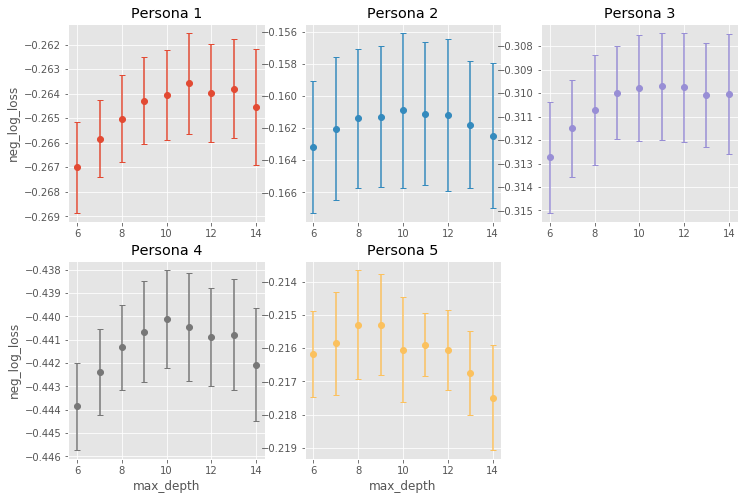

In [136]:
fig,axs = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
palette = sns.color_palette()

for i in xrange(6):
    p = i+1
    try: 
        cv_rf_p = cv_rf.xs(p, level='persona')
        axs[i//3,i%3].errorbar(cv_rf_p['params'].map(lambda d: d['max_depth']), 
                               cv_rf_p['mean_test_score'], 
                               fmt='o', 
                               capsize=3, 
                               yerr=cv_rf_p['std_test_score'], 
                               color=palette[i])
        axs[i//3,i%3].set_title('Persona {}'.format(p))
    except KeyError:
        axs[i//3,i%3].set_axis_off()
    if i//3 == 1:
        axs[i//3,i%3].set_xlabel('max_depth')
    if i%3 == 0:
        axs[i//3,i%3].set_ylabel('neg_log_loss')

In [137]:
%%time

best_params = cv_rf.loc[cv_rf['rank_test_score']==1,'params'].reset_index(level=1, drop=True).to_dict()

fis = slow_apply(udf_train.groupby(partition), 
                 lambda g: part_feature_import(g[keep_features[g.name]], g[target], 
                                               n_estimators=200, random_state=202741, 
                                               oob_score=True, **best_params[g.name]))
fis = fis.reset_index()

CPU times: user 55.6 s, sys: 773 ms, total: 56.4 s
Wall time: 58.3 s


In [138]:
fis

,persona,feature,importance
0,1,tenure_total_months,0.032564
1,1,loyalty_tender_ind,0.011360
2,1,loyalty_nontender_ind,0.011531
3,1,log_fl_total_spend,0.061034
4,1,log_fl_avg_spend_per_trip,0.031537
5,1,sale_pct_items,0.022947
6,1,merch_pct_spend,0.009290
7,1,mens_prod_pct_spend,0.016280
8,1,accessories_pct_spend,0.016722
9,1,apparel_pct_spend,0.021798


In [139]:
binary_features = []
ordinal_features = []
continuous_features = []
for c in features:
    if udf_train[c].nunique() > 8:
        continuous_features.append(c)
    elif udf_train[c].nunique() > 2:
        ordinal_features.append(c)
    else:
        binary_features.append(c)

In [140]:
fis.loc[fis['feature'].isin(continuous_features),'feature_type'] = 'continuous'
fis.loc[fis['feature'].isin(ordinal_features),'feature_type'] = 'ordinal'
fis.loc[fis['feature'].isin(binary_features),'feature_type'] = 'binary'

In [141]:
pvt = fis.loc[fis['feature_type']=='continuous'].pivot(index='feature',columns='persona',values='importance')
pvt.apply(pd.Series.rank, method='min', ascending=False, na_option='keep')

persona,1,2,3,4,5
feature,,,,,
accessories_pct_spend,22.0,23.0,21.0,13.0,21.0
anniversary_early_pct_spend,8.0,34.0,30.0,5.0,11.0
anniversary_public_pct_spend,15.0,9.0,9.0,7.0,5.0
apparel_pct_spend,12.0,10.0,10.0,15.0,17.0
babypet_pct_spend,36.0,36.0,36.0,35.0,35.0
backtoschool_pct_spend,19.0,22.0,20.0,14.0,10.0
bag_pct_spend,31.0,27.0,31.0,29.0,32.0
beauty_pct_spend,17.0,18.0,18.0,25.0,20.0
december_halfyear_pct_spend,30.0,30.0,29.0,28.0,31.0


In [142]:
pvt = fis.loc[fis['feature_type']=='ordinal'].pivot(index='feature',columns='persona',values='importance')
pvt.apply(pd.Series.rank, method='min', ascending=False, na_option='keep')

persona,1,2,3,4,5
feature,,,,,
anniversary_early_pct_shopped,5.0,NaN,14.0,3.0,5.0
anniversary_public_pct_shopped,2.0,NaN,1.0,1.0,1.0
backtoschool_pct_shopped,NaN,NaN,11.0,4.0,3.0
december_halfyear_pct_shopped,8.0,NaN,12.0,12.0,12.0
fall_fashion_pct_shopped,NaN,NaN,9.0,NaN,6.0
fathers_day_pct_shopped,1.0,NaN,4.0,2.0,4.0
holiday_dressing_pct_shopped,NaN,NaN,5.0,13.0,9.0
holiday_full_pct_shopped,NaN,NaN,8.0,10.0,11.0
holiday_light_pct_shopped,7.0,NaN,7.0,7.0,13.0


In [143]:
pvt = fis.loc[fis['feature_type']=='binary'].pivot(index='feature',columns='persona',values='importance')
pvt.apply(pd.Series.rank, method='min', ascending=False, na_option='keep')

persona,1,2,3,4,5
feature,,,,,
anniversary_early_shop_ly_ind,8.0,14.0,15.0,5.0,7.0
anniversary_public_shop_ly_ind,11.0,6.0,5.0,2.0,4.0
backtoschool_shop_ly_ind,7.0,11.0,12.0,6.0,3.0
december_halfyear_shop_ly_ind,16.0,13.0,13.0,14.0,16.0
fall_fashion_shop_ly_ind,12.0,12.0,11.0,13.0,10.0
fathers_day_shop_ly_ind,4.0,2.0,1.0,1.0,1.0
holiday_dressing_shop_ly_ind,5.0,9.0,8.0,10.0,14.0
holiday_full_shop_ly_ind,9.0,10.0,10.0,8.0,12.0
holiday_light_shop_ly_ind,15.0,8.0,7.0,12.0,15.0


In [144]:
fis.to_csv('../data/ep_{0}_feature_importances.csv'.format(key_event_slug), index=False)

In [145]:
fis.groupby('persona')['feature'].count()

persona
1    62
2    54
3    66
4    64
5    66
Name: feature, dtype: int64

In [146]:
fis.loc[fis['persona']==5].sort_values(['feature_type','importance'], ascending=False)

,persona,feature,importance,feature_type
286,5,anniversary_public_pct_shopped,0.026231,ordinal
289,5,spring_fashion_pct_shopped,0.016098,ordinal
293,5,backtoschool_pct_shopped,0.015048,ordinal
297,5,fathers_day_pct_shopped,0.014468,ordinal
285,5,anniversary_early_pct_shopped,0.013059,ordinal
290,5,fall_fashion_pct_shopped,0.012349,ordinal
295,5,valentines_day_pct_shopped,0.011222,ordinal
296,5,mothers_day_pct_shopped,0.009447,ordinal
294,5,holiday_dressing_pct_shopped,0.009359,ordinal
288,5,may_halfyear_pct_shopped,0.008289,ordinal


In [147]:
%%time

param_grid = {'alpha': np.logspace(-5,0,6), 
              'l1_ratio': np.linspace(0,1,6)}
lr_cols = ['months_since_last_squared']

cv_sgd = slow_apply(sdf_train.groupby(partition), 
                    lambda g: part_grid_search(g[keep_features[g.name]+lr_cols], g[target], 
                                               SGDClassifier, param_grid, g.name, 
                                               scoring='neg_log_loss', cv=5, n_jobs=-1, 
                                               loss='log', penalty='elasticnet', 
                                               max_iter=1000))

/Users/c01f/.virtualenvs/devel/lib/python2.7/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/c01f/.virtualenvs/devel/lib/python2.7/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/c01f/.virtualenvs/devel/lib/python2.7/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/c01f/.virtualenvs/devel/lib/python2.7/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


1 SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.4, learning_rate='optimal',
       loss='log', max_iter=1000, n_iter=None, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       tol=None, verbose=0, warm_start=False)


/Users/c01f/.virtualenvs/devel/lib/python2.7/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/c01f/.virtualenvs/devel/lib/python2.7/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


2 SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.8, learning_rate='optimal',
       loss='log', max_iter=1000, n_iter=None, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       tol=None, verbose=0, warm_start=False)
3 SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.4, learning_rate='optimal',
       loss='log', max_iter=1000, n_iter=None, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       tol=None, verbose=0, warm_start=False)
4 SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.4, learning_rate='optimal',
       loss='log', max_iter=1000, n_iter=None, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       tol=None, verbose=0, warm_start=False)


/Users/c01f/.virtualenvs/devel/lib/python2.7/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/c01f/.virtualenvs/devel/lib/python2.7/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/c01f/.virtualenvs/devel/lib/python2.7/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/c01f/.virtualenvs/devel/lib/python2.7/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


5 SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.4, learning_rate='optimal',
       loss='log', max_iter=1000, n_iter=None, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       tol=None, verbose=0, warm_start=False)
CPU times: user 2min 3s, sys: 3.55 s, total: 2min 7s
Wall time: 1h 29min 10s


In [148]:
best_params = cv_sgd.loc[cv_sgd['rank_test_score'] == 1,'params'].reset_index(level=1, drop=True).to_dict()
best_params

{1: {'alpha': 0.001, 'l1_ratio': 0.4},
 2: {'alpha': 0.001, 'l1_ratio': 0.8},
 3: {'alpha': 0.001, 'l1_ratio': 0.4},
 4: {'alpha': 0.001, 'l1_ratio': 0.4},
 5: {'alpha': 0.001, 'l1_ratio': 0.4}}

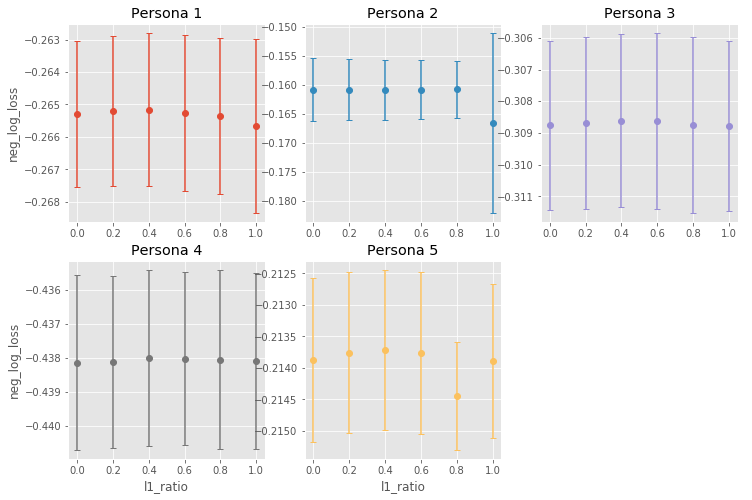

In [149]:
fig,axs = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
palette = sns.color_palette()

for i in xrange(6):
    p = i+1
    try: 
        cv_sgd_p = cv_sgd.xs(p, level='persona')
        cv_sgd_p = cv_sgd_p.loc[cv_sgd_p['params'].map(lambda d: d['alpha']) == best_params[p]['alpha']]
        axs[i//3,i%3].errorbar(cv_sgd_p['params'].map(lambda d: d['l1_ratio']), 
                               cv_sgd_p['mean_test_score'], 
                               fmt='o', 
                               capsize=3, 
                               yerr=cv_sgd_p['std_test_score'], 
                               color=palette[i])
        axs[i//3,i%3].set_title('Persona {}'.format(p))
    except KeyError:
        axs[i//3,i%3].set_axis_off()
    if i//3 == 1:
        axs[i//3,i%3].set_xlabel('l1_ratio')
    if i%3 == 0:
        axs[i//3,i%3].set_ylabel('neg_log_loss')

In [150]:
cv_sgd.loc[cv_sgd['rank_test_score'] <= 5].xs(2, level='persona')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,param_l1_ratio,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
12,24.927259,0.004500,-0.160843,-0.158979,0.001,0,"{u'alpha': 0.001, u'l1_ratio': 0.0}",3,-0.152765,-0.161044,...,-0.162487,-0.158514,-0.161185,-0.158855,-0.169405,-0.156928,2.069252,0.001299,0.005431,0.001344
13,24.217382,0.003717,-0.160871,-0.159241,0.001,0.2,"{u'alpha': 0.001, u'l1_ratio': 0.2}",5,-0.153153,-0.161253,...,-0.162433,-0.158832,-0.160954,-0.159187,-0.169293,-0.157099,5.165568,0.000838,0.005262,0.001354
14,18.444302,0.003578,-0.160858,-0.159338,0.001,0.4,"{u'alpha': 0.001, u'l1_ratio': 0.4}",4,-0.153282,-0.161357,...,-0.162426,-0.158917,-0.160823,-0.159284,-0.169077,-0.157212,0.100716,0.000439,0.005141,0.001350
15,18.749903,0.003218,-0.160824,-0.159441,0.001,0.6,"{u'alpha': 0.001, u'l1_ratio': 0.6000000000000...",2,-0.153327,-0.161457,...,-0.162464,-0.159019,-0.160749,-0.159412,-0.168823,-0.157318,0.154401,0.000178,0.005043,0.001346
16,19.231962,0.003092,-0.160816,-0.159599,0.001,0.8,"{u'alpha': 0.001, u'l1_ratio': 0.8}",1,-0.153469,-0.161609,...,-0.162524,-0.159197,-0.160685,-0.159608,-0.168652,-0.157444,0.325345,0.000025,0.004951,0.001352


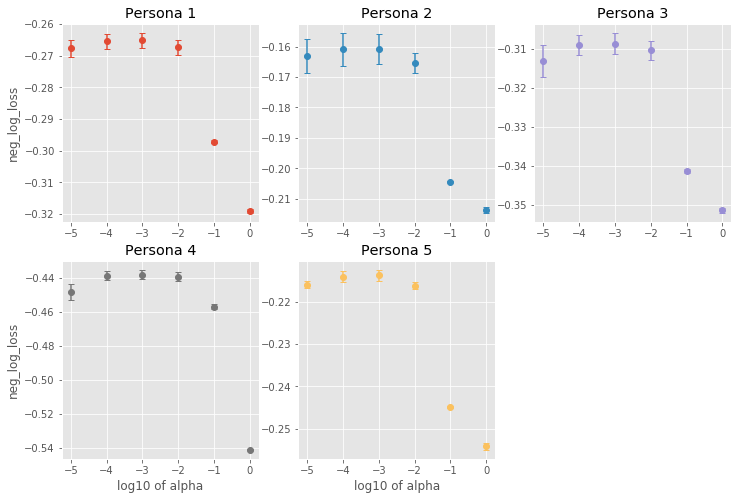

In [151]:
fig,axs = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
palette = sns.color_palette()

for i in xrange(6):
    p = i+1
    try: 
        cv_sgd_p = cv_sgd.xs(p, level='persona')
        cv_sgd_p = cv_sgd_p.loc[cv_sgd_p['params'].map(lambda d: d['l1_ratio']) == best_params[p]['l1_ratio']]
        axs[i//3,i%3].errorbar(np.log10(cv_sgd_p['params'].map(lambda d: d['alpha'])), 
                               cv_sgd_p['mean_test_score'], 
                               fmt='o', 
                               capsize=3, 
                               yerr=cv_sgd_p['std_test_score'], 
                               color=palette[i])
        axs[i//3,i%3].set_title('Persona {}'.format(p))
    except KeyError:
        axs[i//3,i%3].set_axis_off()
    if i//3 == 1:
        axs[i//3,i%3].set_xlabel('log10 of alpha')
    if i%3 == 0:
        axs[i//3,i%3].set_ylabel('neg_log_loss')

In [152]:
def part_bootstrap_coefs(X, y, n_resample=100, label=None, resample_rs=None, sgd_rs=None, **sgd_kwargs):
    coefs = []
    for i in xrange(n_resample):
        if sgd_rs is None:
            mdl = SGDClassifier(**sgd_kwargs)
        else:
            mdl = SGDClassifier(random_state=sgd_rs+i, **sgd_kwargs)
        if resample_rs is None:
            mdl.fit(*resample(X, y))
        else:
            mdl.fit(*resample(X, y, random_state=resample_rs+i))
        coefs.append(mdl.coef_)
    coefs = np.concatenate(coefs)
    coef_df = pd.DataFrame(coefs, columns=X.columns.tolist())
    mean_coefs = coef_df.mean()
    std_coefs = coef_df.std()
    prop_selected = coef_df.apply(lambda x: (np.absolute(x) > 1e-6).astype(int), axis=0).mean()
    df = pd.DataFrame({'prop_selected': prop_selected, 'mean_coef': mean_coefs, 
                       'abs_mean_coef': mean_coefs.abs(), 'std': std_coefs})
    df.index.name = 'feature'
    if label is not None:
        print label, 'Done'
    return df

In [154]:
%%time

opt_params = {'alpha': 0.001, 'l1_ratio': 0.4}
lr_cols = ['months_since_last_squared']

coefs = slow_apply(sdf_train.groupby(partition), 
                   lambda g: part_bootstrap_coefs(g[keep_features[g.name]+lr_cols], g[target], 
                                                  label=g.name, resample_rs=4040, sgd_rs=8889, 
                                                  loss='log', penalty='elasticnet', 
                                                  max_iter=1000, **opt_params))
coefs = coefs.reset_index()

1 Done
2 Done
3 Done
4 Done
5 Done
CPU times: user 2h 29min 5s, sys: 56.1 s, total: 2h 30min 1s
Wall time: 2h 32min 22s


In [167]:
coefs.loc[coefs['persona']==2].sort_values(['persona','prop_selected','abs_mean_coef'], ascending=[True, False, False])

,persona,feature,abs_mean_coef,mean_coef,prop_selected,std
67,2,log_fl_total_trips,0.629876,0.629876,1.00,0.050487
65,2,loyalty_nontender_ind,0.515002,0.515002,1.00,0.020085
117,2,months_since_last_squared,0.378123,0.378123,1.00,0.023054
86,2,fl_total_divs,0.332539,0.332539,1.00,0.054466
88,2,months_since_last_sale,0.253620,-0.253620,1.00,0.065215
115,2,mothers_day_shop_ly_ind,0.114555,0.114555,1.00,0.032919
71,2,mens_prod_pct_spend,0.109559,-0.109559,1.00,0.031153
105,2,anniversary_public_shop_ly_ind,0.109435,0.109435,1.00,0.040312
69,2,sale_pct_items,0.101789,0.101789,1.00,0.022512
80,2,jewelry_pct_spend,0.055864,-0.055864,0.99,0.024729


In [158]:
coefs['persona'].value_counts()

5    67
3    67
4    65
1    63
2    55
Name: persona, dtype: int64

In [159]:
coefs.to_csv('../data/ep_{0}_bootstrapped_coefs.csv'.format(key_event_slug), index=False)

In [160]:
coefs.loc[coefs['prop_selected']>0.5,'persona'].value_counts()

4    59
3    59
1    57
5    52
2    38
Name: persona, dtype: int64

In [206]:
p = 1
n = 36
fis_p = fis.loc[fis[partition]==p]
ft_exps = fis_p['feature_type'].value_counts() * n / len(fis_p)
ft_nums = np.floor(ft_exps).astype('int64')
nleft = n - ft_nums.sum()
ft_rmdr = ((ft_exps - ft_nums).rank(method='first', ascending=False) <= nleft).astype('int64')
ft_nums += ft_rmdr
print (fis_p.groupby('feature_type')['importance'].rank(ascending=False) <= fis_p['feature_type'].map(ft_nums)).head(15)
print fis_p.head(15)

0      True
1      True
2      True
3      True
4      True
5      True
6     False
7     False
8      True
9      True
10     True
11    False
12     True
13     True
14    False
dtype: bool
    persona                      feature  importance feature_type
0         1          tenure_total_months    0.029605   continuous
1         1           loyalty_tender_ind    0.008845       binary
2         1        loyalty_nontender_ind    0.026528       binary
3         1               fl_total_spend    0.062346   continuous
4         1        fl_avg_spend_per_trip    0.039050   continuous
5         1               sale_pct_items    0.025562   continuous
6         1              merch_pct_spend    0.014042   continuous
7         1          mens_prod_pct_spend    0.018263   continuous
8         1                web_pct_spend    0.068167   continuous
9         1               rack_pct_spend    0.024336   continuous
10        1                fl_total_divs    0.046570   continuous
11        1     

In [327]:
def top_important_features(df, top_n, var_col, value_col, stratify_col):
    if isinstance(top_n, int):
        if top_n >= len(df):
            return df[var_col].tolist()
        ft_exps = df[stratify_col].value_counts() * top_n / len(df)
        ft_nums = np.floor(ft_exps).astype('int64')
        n_rmn = top_n - ft_nums.sum()
        ft_nums += ((ft_exps - ft_nums).rank(method='first', ascending=False) <= n_rmn).astype('int64')
    elif isinstance(top_n, (dict, pd.Series)):
        ft_nums = pd.Series(top_n)
    #print ft_nums
    selected = (df.groupby(stratify_col)[value_col].rank(ascending=False) <= df[stratify_col].map(ft_nums))
    return df.loc[selected, var_col].tolist()

In [328]:
fis.loc[fis['persona']==1].sort_values(['feature_type','importance'], ascending=False)

,persona,feature,importance,feature_type
47,1,fathers_day_pct_shopped,0.017109,ordinal
41,1,anniversary_public_pct_shopped,0.014975,ordinal
46,1,mothers_day_pct_shopped,0.013145,ordinal
43,1,may_halfyear_pct_shopped,0.011771,ordinal
40,1,anniversary_early_pct_shopped,0.009400,ordinal
45,1,valentines_day_pct_shopped,0.008755,ordinal
44,1,holiday_light_pct_shopped,0.007616,ordinal
42,1,december_halfyear_pct_shopped,0.006419,ordinal
23,1,total_channels,0.006192,ordinal
25,1,log_fl_total_spend_ly,0.064084,continuous


In [329]:
fis['persona'].value_counts()

5    66
3    66
4    64
1    62
2    54
Name: persona, dtype: int64

In [345]:
n_picked = {1: 51, 2: 45, 3: {'continuous': 32, 'binary': 13, 'ordinal': 11}, 4: 55, 5: {'continuous': 32, 'binary': 12, 'ordinal': 10}}
selected_rf_features = fis.groupby('persona').apply(lambda g: top_important_features(g, n_picked[g.name], 'feature', 'importance', 'feature_type'))

In [346]:
'home_pct_spend' in selected_rf_features[4]

False

In [347]:
selected_rf_features.map(len)

persona
1    51
2    45
3    56
4    55
5    54
dtype: int64

In [348]:
rf_udf_train = udf_train.groupby('persona').apply(lambda g: g[['cust_key','persona','target_shopped_ind']+selected_rf_features[g.name]])
rf_column_order = [c for c in udf_train.columns if c in rf_udf_train.columns]
rf_udf_train[rf_column_order].to_csv('../data/ep_{0}_rf_train_data.csv.gz'.format(key_event_slug), 
                                     sep='|', index=False, compression='gzip')

In [349]:
rf_udf_test = udf_test.groupby('persona').apply(lambda g: g[['cust_key','persona','target_shopped_ind']+selected_rf_features[g.name]])
rf_column_order = [c for c in udf_test.columns if c in rf_udf_test.columns]
rf_udf_test[rf_column_order].to_csv('../data/ep_{0}_rf_test_data.csv.gz'.format(key_event_slug), 
                                    sep='|', index=False, compression='gzip')

In [350]:
rf_udf_train[rf_column_order].head()

,cust_key,persona,target_shopped_ind,tenure_total_months,loyalty_tender_ind,loyalty_nontender_ind,log_fl_total_spend,log_fl_total_trips,log_fl_avg_spend_per_trip,sale_pct_items,...,wellness_shop_ly_ind,spring_fashion_shop_ly_ind,fall_fashion_shop_ly_ind,holiday_light_shop_ly_ind,holiday_full_shop_ly_ind,backtoschool_shop_ly_ind,holiday_dressing_shop_ly_ind,valentines_day_shop_ly_ind,mothers_day_shop_ly_ind,fathers_day_shop_ly_ind
0,124872002,5,0,68.000000,1.0,NaN,8.544026,NaN,5.285929,2.272727,...,1.0,1,1,NaN,0,1,NaN,1.0,1,1
1,116227080,5,0,5.290323,0.0,NaN,5.785332,NaN,5.785332,0.000000,...,1.0,0,0,NaN,0,0,NaN,1.0,0,0
2,48616289,3,0,47.967742,NaN,0.0,6.504288,NaN,5.405676,0.000000,...,NaN,0,0,0.0,0,0,1.0,0.0,0,0
3,74960102,4,1,29.612903,0.0,NaN,5.513469,NaN,4.414857,0.000000,...,NaN,0,0,0.0,0,0,0.0,0.0,0,0
4,101857700,3,0,12.032258,NaN,1.0,3.636270,NaN,3.636270,0.000000,...,NaN,0,0,0.0,0,0,0.0,0.0,0,0


In [275]:
coefs.head()

,persona,feature,abs_mean_coef,mean_coef,prop_selected,std
0,1,tenure_total_months,0.064931,-0.064931,0.69,0.084647
1,1,loyalty_tender_ind,0.254952,0.254952,1.00,0.054751
2,1,loyalty_nontender_ind,1.153957,1.153957,1.00,0.055891
3,1,fl_total_spend,2.647680,2.647680,1.00,0.616482
4,1,fl_avg_spend_per_trip,1.689617,-1.689617,0.99,0.509558


In [341]:
coefs.loc[coefs['persona']==5].sort_values(['prop_selected','abs_mean_coef'], ascending=False).head(55)

,persona,feature,abs_mean_coef,mean_coef,prop_selected,std
253,5,log_fl_total_spend,0.483085,0.483085,1.00,0.071178
273,5,months_since_last_sale,0.230060,-0.230060,1.00,0.064976
251,5,loyalty_tender_ind,0.200759,0.200759,1.00,0.029438
254,5,log_fl_avg_spend_per_trip,0.197336,-0.197336,1.00,0.046964
252,5,loyalty_nontender_ind,0.178498,0.178498,1.00,0.024766
270,5,rack_pct_spend,0.173511,0.173511,1.00,0.024565
271,5,fl_total_divs,0.142735,0.142735,1.00,0.042476
255,5,sale_pct_items,0.094298,0.094298,1.00,0.027173
316,5,months_since_last_squared,0.092176,0.092176,1.00,0.021052
290,5,anniversary_public_pct_shopped,0.084112,0.084112,1.00,0.033469


In [169]:
def top_bootstrapped_features(df, top_n, var_col, value_cols):
    return df.sort_values(value_cols, ascending=False)[var_col].head(top_n).tolist()

In [170]:
def threshold_bootstrapped_features(df, prop_th, var_col, value_col, min_n=0, sort_cols=None):
    if sort_cols is None:
        sort_cols = []
    if (df[value_col] > prop_th).sum() < min_n:
        return df.sort_values([value_col]+sort_cols, ascending=False)[var_col].head(min_n).tolist()
    else:
        return df.loc[df[value_col] > prop_th, var_col].tolist()

In [289]:
coefs.groupby('persona').apply(top_bootstrapped_features, 35, 'feature', ['prop_selected','abs_mean_coef'])

persona
1    [fl_total_spend, loyalty_nontender_ind, web_pc...
2    [fl_total_trips, loyalty_nontender_ind, fl_tot...
3    [fl_avg_spend_per_trip, loyalty_nontender_ind,...
4    [fl_avg_spend_per_trip, fl_total_spend, fl_tot...
5    [fl_total_spend, fl_total_divs, rack_pct_spend...
dtype: object

In [333]:
coefs.groupby('persona').apply(threshold_bootstrapped_features, 0.5, 'feature', 'prop_selected', 49, ['abs_mean_coef'])

persona
1    [tenure_total_months, loyalty_tender_ind, loya...
2    [log_fl_total_trips, loyalty_nontender_ind, mo...
3    [tenure_total_months, loyalty_tender_ind, loya...
4    [tenure_total_months, loyalty_tender_ind, loya...
5    [loyalty_tender_ind, loyalty_nontender_ind, lo...
dtype: object

In [351]:
n_picked = {1: 57, 2: 49, 3: 60, 4: 59, 5: 55}
selected_lr_features = coefs.groupby('persona').apply(lambda g: top_bootstrapped_features(g, n_picked[g.name], 'feature', ['prop_selected','abs_mean_coef']))

In [352]:
selected_lr_features.map(len)

persona
1    57
2    49
3    60
4    59
5    55
dtype: int64

In [353]:
lr_sdf_train = sdf_train.groupby('persona').apply(lambda g: g[['cust_key','persona','target_shopped_ind']+selected_lr_features[g.name]])
lr_column_order = [c for c in sdf_train.columns if c in lr_sdf_train.columns]
lr_sdf_train[lr_column_order].to_csv('../data/ep_{0}_lr_train_data.csv.gz'.format(key_event_slug), 
                                     sep='|', index=False, compression='gzip')

In [354]:
lr_sdf_test = sdf_test.groupby('persona').apply(lambda g: g[['cust_key','persona','target_shopped_ind']+selected_lr_features[g.name]])
lr_column_order = [c for c in sdf_test.columns if c in lr_sdf_test.columns]
lr_sdf_test[lr_column_order].to_csv('../data/ep_{0}_lr_test_data.csv.gz'.format(key_event_slug), 
                                    sep='|', index=False, compression='gzip')

In [355]:
lr_sdf_train[lr_column_order].head()

,cust_key,persona,target_shopped_ind,tenure_total_months,loyalty_tender_ind,loyalty_nontender_ind,log_fl_total_spend,log_fl_total_trips,log_fl_avg_spend_per_trip,sale_pct_items,...,spring_fashion_shop_ly_ind,fall_fashion_shop_ly_ind,holiday_light_shop_ly_ind,holiday_full_shop_ly_ind,backtoschool_shop_ly_ind,holiday_dressing_shop_ly_ind,valentines_day_shop_ly_ind,mothers_day_shop_ly_ind,fathers_day_shop_ly_ind,months_since_last_squared
0,124872002,5,0,NaN,1.582778,-0.401009,1.476510,NaN,0.636007,-0.383641,...,1.822416,2.062598,-0.438308,-0.58775,1.974157,1.251212,2.092445,2.142341,2.077207,1.245940
1,116227080,5,0,NaN,-0.631800,2.493708,-0.181910,NaN,1.255431,-0.491861,...,-0.548722,-0.484826,-0.438308,-0.58775,-0.506545,-0.799225,2.092445,-0.466779,-0.481416,0.034927
2,48616289,3,0,0.163316,-0.631800,-0.401009,0.250299,NaN,0.784532,-0.491861,...,-0.548722,-0.484826,-0.438308,-0.58775,-0.506545,1.251212,-0.477910,-0.466779,-0.481416,0.007817
3,74960102,4,1,-0.309379,-0.631800,-0.401009,-0.345343,NaN,-0.444412,-0.491861,...,-0.548722,-0.484826,-0.438308,-0.58775,-0.506545,-0.799225,-0.477910,-0.466779,-0.481416,11.276865
4,101857700,3,0,-0.762136,-0.631800,2.493708,-1.473842,NaN,-1.410119,-0.491861,...,-0.548722,-0.484826,-0.438308,-0.58775,-0.506545,-0.799225,-0.477910,-0.466779,-0.481416,1.208687


In [136]:
selected_lr_features.map(len)

persona
1    43
2    37
3    49
4    49
5    42
dtype: int64

In [373]:
all_possible_features = udf_train.columns.tolist()[3:]

In [374]:
def item_in_list(rf, items):
    ser = pd.Series(data=[int(i in rf) for i in items], index=items)
    return ser

In [375]:
selected_rf_features_df = selected_rf_features.apply(item_in_list, args=(all_possible_features,))
selected_rf_features_df.T

persona,1,2,3,4,5
tenure_total_months,1,1,1,1,1
loyalty_tender_ind,1,0,0,1,1
loyalty_nontender_ind,1,1,1,0,0
log_fl_total_spend,1,1,1,1,1
log_fl_total_trips,0,1,0,0,0
log_fl_avg_spend_per_trip,1,1,1,1,1
sale_pct_items,1,1,1,1,1
merch_pct_spend,0,0,1,0,1
womens_prod_pct_spend,0,0,0,0,0
mens_prod_pct_spend,1,1,1,1,1


In [381]:
selected_rf_features_df.T.loc[(selected_rf_features_df.T).any(axis=1)].tail(60)

persona,1,2,3,4,5
log_fl_total_spend,1,1,1,1,1
log_fl_total_trips,0,1,0,0,0
log_fl_avg_spend_per_trip,1,1,1,1,1
sale_pct_items,1,1,1,1,1
merch_pct_spend,0,0,1,0,1
mens_prod_pct_spend,1,1,1,1,1
accessories_pct_spend,1,1,1,1,1
apparel_pct_spend,1,1,1,1,1
bag_pct_spend,1,1,1,1,1
beauty_pct_spend,1,1,1,1,1


In [384]:
rf_cols = rf_column_order[3:]
for p in xrange(1,6):
    nc, no, nb = 0,0,0
    for c in rf_cols:
        if rf_udf_train.loc[rf_udf_train['persona']==p,c].isnull().all():
            continue
        if rf_udf_train[c].nunique() > 8:
            nc += 1
        elif rf_udf_train[c].nunique() > 2:
            no += 1
        else:
            nb += 1
    print p, nb, no, nc, nb+no+nc

1 13 7 31 51
2 12 1 32 45
3 13 11 32 56
4 13 11 31 55
5 12 10 32 54
